In this project we are working to create an algorithm to identify metastatic cancer in small image patches take from larger digital pathology scans.

Github: https://github.com/KingSherriff/CNN-Cancer-Detection-Kaggle-Mini-Project

## Import Packages

In [2]:
import os
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation

2025-12-07 09:52:21.267285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765101141.716012    4275 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765101141.821841    4275 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

## Import Data

In [3]:
train_img_dir = "/kaggle/input/histopathologic-cancer-detection/train"
test_img_dir  = "/kaggle/input/histopathologic-cancer-detection/test"
sample_sub_dir  = "/kaggle/input/histopathologic-cancer-detection/sample_submission.csv"
train_labels = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")

train_labels_ids = set(train_labels["id"])
train_img_ids = set(data.replace(".tif", "") for data in os.listdir(train_img_dir))

In [4]:
def get_data_info():
    sample_path = os.path.join(train_img_dir, train_labels["id"].iloc[0] + ".tif")
    print("Image shape:", np.array(Image.open(sample_path)).shape)
    print("Train Labels Shape:", train_labels.shape, "\n")
    print(train_labels.describe(), "\n")
    print(train_labels.info(), "\n")
    print(train_labels.head(), "\n")

def check_all_images_accounted_for():
    missing_images = train_labels_ids - train_img_ids
    print("Missing images:", len(missing_images))
    if len(missing_images) > 0:
        print(list(missing_images)[:10])
    
    extra_images = train_img_ids - train_labels_ids
    print("Extra unlabeled images:", len(extra_images))
    if len(extra_images) > 0:
        print(list(extra_images)[:10])
    print('Duplicated data:',train_labels.duplicated().sum())
    print("\n")

def show_random_images(label, n=8):
    ids = train_labels[train_labels["label"] == label]["id"].sample(n).values
    
    plt.figure(figsize=(10,5))
    for i, img_id in enumerate(ids):
        img_path = os.path.join(train_img_dir, img_id + ".tif")
        img = Image.open(img_path)
        plt.subplot(2, n//2, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Random Samples: Label {label}")
    plt.show()

# EDA
We will begin with some initial analysis of the datasets to better understand its meta composition through shape, feature types, repeating data, missing values, etc. As we are dealing with image data we will also check the shape of the image. This will give us a much better idea of the data we are working with as well as help us identify if any cleaning will be required.

## Dataset Overview

Image shape: (96, 96, 3)
Train Labels Shape: (220025, 2) 

               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None 

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0 

Missing images: 0
Extra unlabeled images: 0
Duplicated data: 0




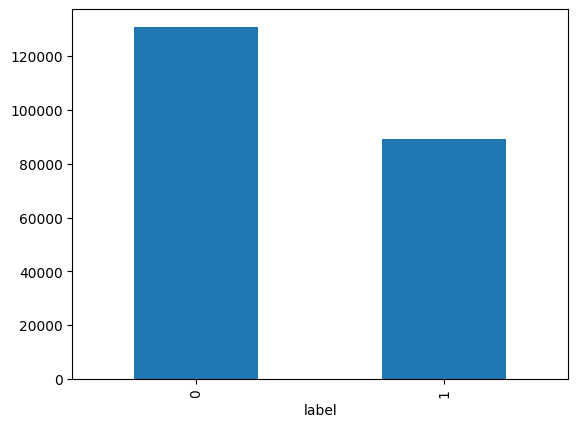

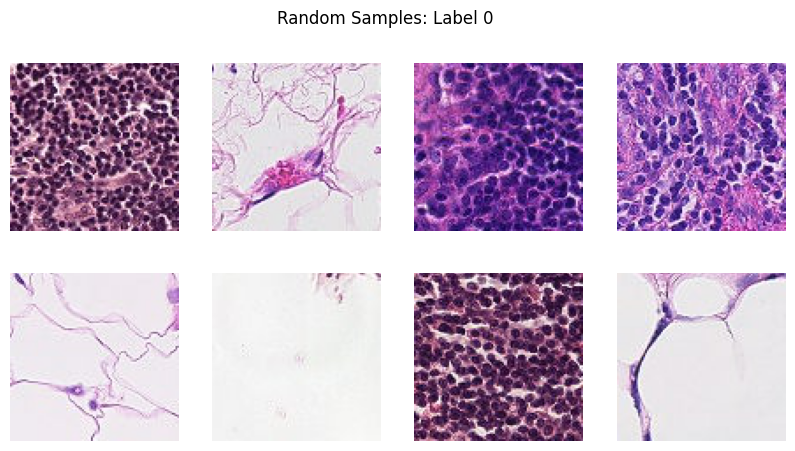

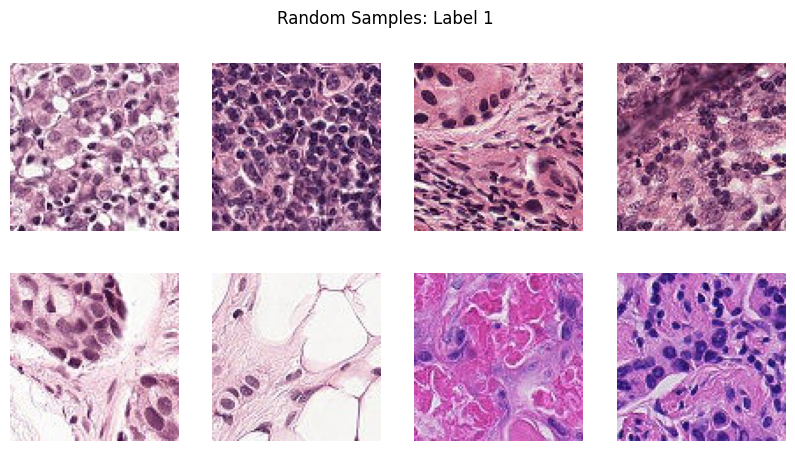

In [5]:
get_data_info()
check_all_images_accounted_for()
train_labels['label'].value_counts().plot(kind='bar')
show_random_images(0)
show_random_images(1)

## Evaluating Data
We can see that our data is pretty clean. We have 220025 images that are labeled either 0 or 1 representing 'no tumor' or 'tumor', each 96 by 96 pixels in the rgb spectrum. We have no duplicates and every image is associated with a label and vis versa. We should of course note that there is a clear distribution in results with about 60% of the data being 'no tumor' and 40% being 'tumor'. This may skew our model so we will limit our training data to ensure an even distribution which will also decrease our training time.

Since our data is so clean, it does not require any further cleaning and we will use it as is. Our plan of analysis will be cutting the data down to 10% randomly selected samples to analyse from both labels. Further we will train on multiple models including a simple CNN, a more complex CNN, and a small pre-trained model. We will evaluate the training-validation split, observe our loss, and check each model's accuracy using the sample_submission data. Finally based on model performance we will further refine one or more models using specialized techniques and hyper-parameter tuning.

## Collect Sample data

In [6]:
def load_images(labelsIn, img_dir):
    images = []
    labels = labelsIn['label'].values

    for img_id in labelsIn['id']:
        images.append(Image.open(f"{train_img_dir}/{img_id}.tif"))
    return np.array(images), np.array(labels)

train_sample, validate_sample = train_test_split(train_labels, test_size=0.1, stratify=train_labels.label, random_state=42)
train_sample = train_sample.sample(22002, random_state=42)
validate_sample = validate_sample.sample(5500, random_state=42)

In [7]:
X_train, y_train = load_images(train_sample, train_img_dir)
X_validate, y_validate = load_images(validate_sample, train_img_dir)
X_train = X_train / 255.0
X_validate = X_validate / 255.0

# Model
We will be training multiple models to target this problem including a simple CNN based on the VGGNet model and a custom CNN model built based on the simple model. I had initially selected the simpleCNN to test the model and make refined improvements as I create a model more towards an VGGNet but with hyperparamaters refined towards this specific problem. Some of the refinements were expected such as the use of batch normalization and increased convolutional layers while others such as the need to divide the RGB data by 255 and sticking to around 12 to 13 epoch were trial tested refinements that will be discussed in the end.

## Simple CNN

In [8]:
class SimpleCNN:
    def __init__(self, input_shape=(96,96,3)):
        self.input_shape = input_shape
        self.model = self.build_model()
        self.history = None
    
    def build_model(self):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape = self.input_shape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    def show_model(self):
        self.model.summary()
    
    def train(self, train_data, train_labels, validate_data, epochs = 5):
        self.history = self.model.fit(train_data, train_labels, epochs=epochs, validation_data=validate_data)
        return self.history
    
    def display_results(self, X_validate, y_validate):
        fig, axs = plt.subplots(1, 2, figsize=(14,5))

        axs[0].plot(self.history.history['accuracy'], label='accuracy')
        axs[0].plot(self.history.history['val_accuracy'], label='val_accuracy')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Accuracy')
        axs[0].set_ylim([0, 1])
        axs[0].legend()
        axs[0].set_title('Accuracy over Epochs')
        
        axs[1].plot(self.history.history['loss'], label='train_loss')
        axs[1].plot(self.history.history['val_loss'], label='val_loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')
        axs[1].legend()
        axs[1].set_title('Loss over Epochs')
    
        plt.show()

        y_pred = (self.model.predict(X_validate) > 0.5).astype(int)
        cm = confusion_matrix(y_validate, y_pred, labels=[0, 1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(xticks_rotation=45)

## Refined CNN

In [9]:
class RefinedCNN:
    def __init__(self, input_shape=(96,96,3)):
        self.input_shape = input_shape
        self.model = self.build_model()
        self.history = None
    
    def build_model(self):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), input_shape = self.input_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3), input_shape = self.input_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D((2, 2)))
        
        model.add(Conv2D(64, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D((2, 2)))
        
        model.add(Conv2D(128, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(128, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D((2, 2)))
        
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        opt = AdamW(learning_rate=1e-4, weight_decay=1e-5)
        model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    def show_model(self):
        self.model.summary()
    
    def train(self, train_data, train_labels, validate_data, epochs = 5):
        self.history = self.model.fit(train_data, train_labels, epochs=epochs, validation_data=validate_data)
        return self.history
    
    def display_results(self, X_validate, y_validate):
        fig, axs = plt.subplots(1, 2, figsize=(14,5))

        axs[0].plot(self.history.history['accuracy'], label='accuracy')
        axs[0].plot(self.history.history['val_accuracy'], label='val_accuracy')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Accuracy')
        axs[0].set_ylim([0, 1])
        axs[0].legend()
        axs[0].set_title('Accuracy over Epochs')
        
        axs[1].plot(self.history.history['loss'], label='train_loss')
        axs[1].plot(self.history.history['val_loss'], label='val_loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')
        axs[1].legend()
        axs[1].set_title('Loss over Epochs')
    
        plt.show()

        y_pred = (self.model.predict(X_validate) > 0.5).astype(int)
        cm = confusion_matrix(y_validate, y_pred, labels=[0, 1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(xticks_rotation=45)

In [10]:
simple_model = SimpleCNN()
simple_model.train(X_train, y_train, (X_validate, y_validate), 10)
simple_test_loss, simple_test_acc = simple_model.model.evaluate(X_train,  y_train)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1765101404.885515    4275 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765101404.886104    4275 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/10


I0000 00:00:1765101414.952388    4312 service.cc:148] XLA service 0x7951dc005440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765101414.953720    4312 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765101414.953746    4312 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765101415.389845    4312 cuda_dnn.cc:529] Loaded cuDNN version 90300


 16/688 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.4850 - loss: 1.1844 

I0000 00:00:1765101418.775337    4312 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


688/688 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.7102 - loss: 0.5827 - val_accuracy: 0.7998 - val_loss: 0.4412
Epoch 2/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7914 - loss: 0.4602 - val_accuracy: 0.8022 - val_loss: 0.4358
Epoch 3/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8083 - loss: 0.4240 - val_accuracy: 0.8184 - val_loss: 0.4098
Epoch 4/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8314 - loss: 0.3862 - val_accuracy: 0.8058 - val_loss: 0.4358
Epoch 5/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8664 - loss: 0.3182 - val_accuracy: 0.8189 - val_loss: 0.4608
Epoch 6/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9107 - loss: 0.2287 - val_accuracy: 0.7967 - val_loss: 0.5561
Epoch 7/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9434 - loss: 0.1513 - val_accuracy: 0.8045 - val_loss: 0.6918
Epoch 8/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9654 - loss: 0.0966 - val_accuracy: 0.80

In [17]:
refined_model = RefinedCNN()
refined_model.train(X_train, y_train, (X_validate, y_validate), 9)
refined_test_loss, refined_test_acc = refined_model.model.evaluate(X_train,  y_train)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/9
688/688 ━━━━━━━━━━━━━━━━━━━━ 33s 36ms/step - accuracy: 0.7567 - loss: 0.5309 - val_accuracy: 0.8298 - val_loss: 0.3895
Epoch 2/9
688/688 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.8129 - loss: 0.4292 - val_accuracy: 0.8291 - val_loss: 0.3816
Epoch 3/9
688/688 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.8322 - loss: 0.4010 - val_accuracy: 0.8178 - val_loss: 0.4046
Epoch 4/9
688/688 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.8331 - loss: 0.3863 - val_accuracy: 0.8558 - val_loss: 0.3347
Epoch 5/9
688/688 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.8458 - loss: 0.3663 - val_accuracy: 0.8013 - val_loss: 0.5324
Epoch 6/9
688/688 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.8527 - loss: 0.3472 - val_accuracy: 0.8553 - val_loss: 0.3294
Epoch 7/9
688/688 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.8578 - loss: 0.3363 - val_accuracy: 0.8633 - val_loss: 0.3123
Epoch 8/9
688/688 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.8700 - loss: 0.3159 - val_accu

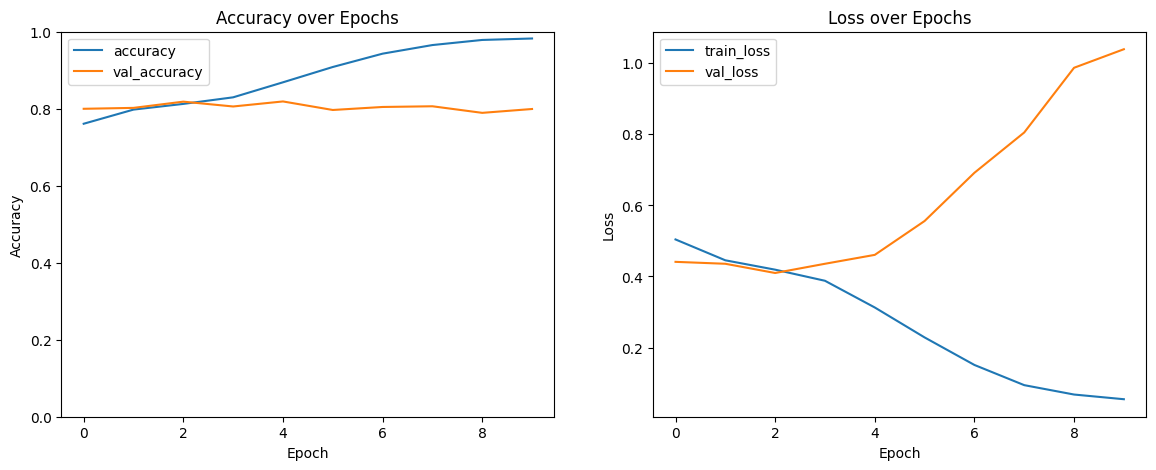

172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


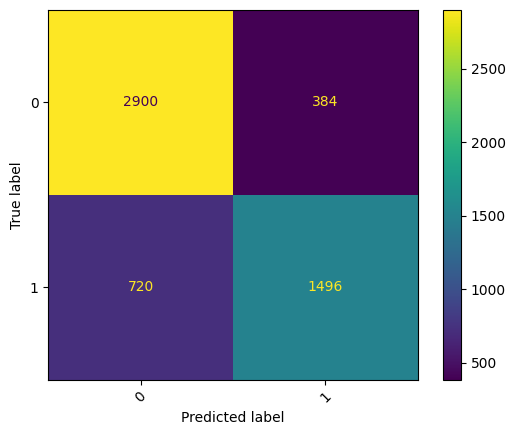

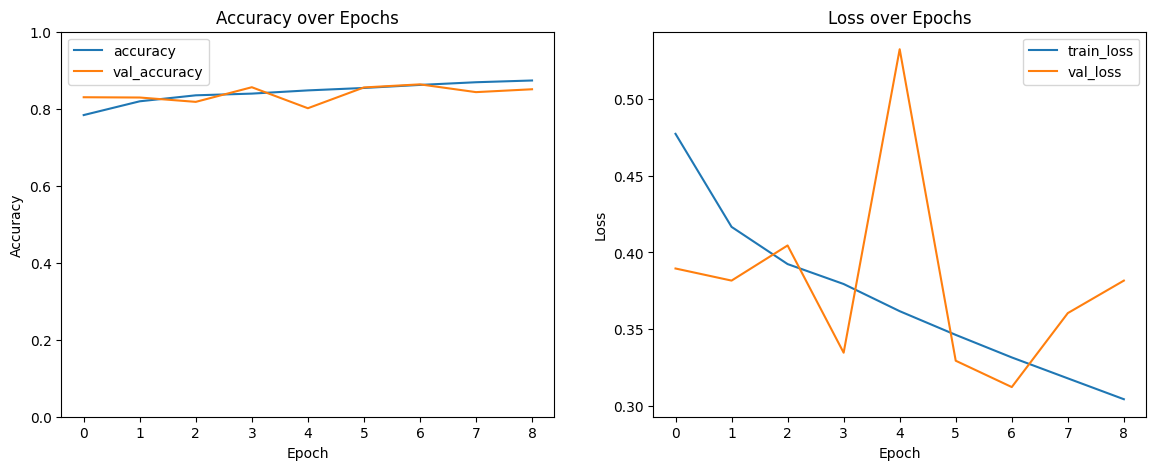

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


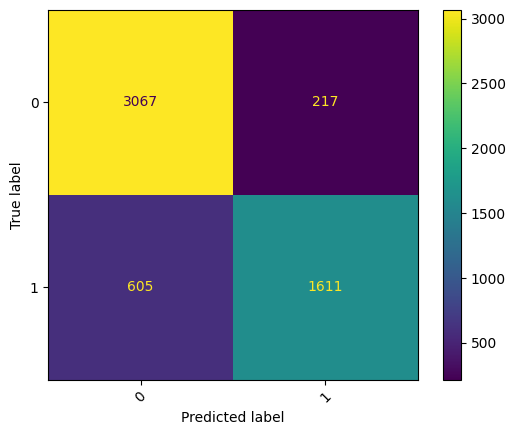

In [18]:
simple_model.display_results(X_validate, y_validate)
refined_model.display_results(X_validate, y_validate)

In [19]:
def load_test(filename, img_dir):
    path = os.path.join(img_dir, filename)
    img = Image.open(path).convert("RGB")
    arr = np.array(img, dtype=np.float32) / 255.0
    return arr

sample_sub = pd.read_csv(sample_sub_dir)
test_ids = sample_sub['id'].values
test_files = [f"{tid}.tif" for tid in test_ids]

bsize = 256
preds = []

for i in range(0, len(test_files), bsize):
    bfiles = test_files[i:i + bsize]
    bimgs = np.array([load_test(file, test_img_dir) for file in bfiles])
    preds.extend(refined_model.model.predict(bimgs, verbose=0).reshape(-1))

labels = (np.array(preds) > 0.5).astype(int)
submission = pd.DataFrame({"id": test_ids, "label": labels})
submission.to_csv("/kaggle/working/submission.csv", index=False)

# Results, Analysis, and Discussion
As can be seen here we trained two models, a simpleCNN and a refinedCNN. Our simpleCNN was to get an understanding of how our basic model performs so we could refine it without getting bogged down in certain models or approaches that may be inherantly limited. Much of the most significant refinements were expected such as more layers and making use of BatchNormalization, Dropout, and more convolutional layers. Some things that were changed but aren't reflected in the report are that we had limited the data to 1% of the total in order to speed up calculations but this had quickly resulted in overfitting. To counter this we increased the amount of data used but our simple model continued to overfit likely due to the lack of regularization in the form of batch normalization and dropout. This was seen clearly when the refined model continued to become more accurate without overfitting when this was applied. These refinements alongside weighted decay optimization were increadiblly effective, however there was significant initial error in both models regardless of improvements. After observing the models it became clear the the lack of normalization in the RGB data resulted in an initial confusion that the model could eventually get past. While multiple optimization methods were attempted, it was still found that weighted adam was most consitantly affected. Finally it was observed that even the refined model would consistantly overfit after 10 to 12 epochs and so the hyperparameter was refined to 9 in order to allow for more potential.

One thing that was distinctly learned was how deeply aspects of the model change other aspects of the mdoel. While making changes and adjusting hyperparameters resulted in distinct improvements, it was easy to find some adjustments such as data size, normalizations, and epochs that would result in a notable decrease in performance. When this is paired with changes that interact with each other it becomes quite difficult to identify exactly what combinations of hyperparameters and optimizations result in better or worse outcomes even with data such as accuracy. This could likely be resolved by running several models with minor adjustments side by side and compare the results algorithmically but this would be far too expensive and time consuming.

Our final result for our refined model appears a bit shaky in the validate accuracy as it fluctuates throughout the training, however overall we recieve a respectable 0.8 accuracy in the training set and 0._ in the final testing submission set.